<a href="https://colab.research.google.com/github/YesidBelloC/BMSFormation/blob/main/Kalman_Filter_Excercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Welcome to the Kalman filter excercise.**

The main objective of this excercise is to help you to understand the theoretical aspects and give you an environment to make experiments.

The model used is goint to be the circuital representation of the lithium battery with only on RC circuit (Fig 1). The reason of that is because those parameters can be estimated easily by experimental data.


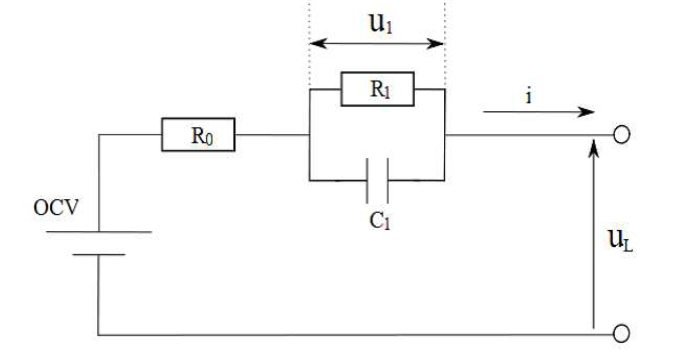

Figure 1: Battery circuit representation.
The equation that describe the model are:
\\begin{equation*}
  C_{1}\frac{δU_{1}}{δt}+\frac{U_{1}}{R_{1}}=I
  \end{equation*}
\\begin{equation*}
  U_{L}=VoC(SoC)+U_{l}+R_{O}I
  \end{equation*}
\\begin{equation*}
  \frac{δSoC}{δt}=\frac{I}{Fcc}
\end{equation*}
In discrete fore they are:
\\begin{equation*}
  U_{K+1}=(1-\frac{\Delta t}{R_{1}C_{1}})U_{k}+(\frac{\Delta t}{C_{1}})I_{K}
  \end{equation*}
\\begin{equation*}
  Y_{K}=VoC(SoC_{k})-R_{O_{k}}I_{K}-U_{1_{k}}
  \end{equation*}
\\begin{equation*}
  SoC_{K+1}=SoC_{K}+\frac{\Delta t}{Fcc}I_{K}
  \end{equation*}
Since the input is current:
\\begin{equation*}
  U = \begin{bmatrix}
I
\end{bmatrix}
\end{equation*}
And the model states are: State of charge, RC circuit voltaje and internal resistance:
\\begin{equation*}
  X = \begin{bmatrix}
SoC\\
U_{RC}\\
R_{o}
\end{bmatrix}
\end{equation*}

The model in discret form is:
\\begin{equation*}
  X_{k+1} = \begin{bmatrix}
1 & 0 & 0\\
0 & (1-\frac{\Delta t}{R_{1}C_{1}}) & 0\\
0 & 0 & 1
\end{bmatrix}
X_{k}+\begin{bmatrix}
\frac{\Delta t}{Fcc}\\
\frac{\Delta t}{C_{1}}\\
0
\end{bmatrix}
U_{k}
\end{equation*}

For more information read: "Accurate SoC Estimation of Lithium-Ion Batteries Based on Parameter-Dependent State-Space Model", DOI: 10.1109/ISCIT.2015.7458301. 2015.


Let's begging the code. First, make libraries imports:

In [ ]:
import pandas as pd
import csv
from numpy import *
import numpy as np
import matplotlib.pyplot as plt
import random as rnd

from Matrix import MatrixConception
from JoinChargeDecharge import JoinChargeDecharge
from VoCSoC import VoCSoC
Matrix_data = MatrixConception()

Now you have to iniitialize each variable:

In [ ]:

# Parametros de Simulacion y Bateria
Delt_T= 0.5         #[s] Temps d'échantillonnage
Qr=Matrix_data.Capacity*3600   #[Ah] Capacité totale

# Definition des matrices de bruit
#x=[SoC u1 Ro]
Xo=np.array([0.7,0.125,0.2567])       #Etat initial
Po=np.diag(ones(3))                          #Incertitude initial I3 paper
sigmaSoCk=0.0003                             #0.1;               %Bruit messure SoC
sigmaU1k =1.5                                #0.3162 #0.032      %Bruit Messure Tension RC|
sigmaRo  =0.00001                            #Bruit Messure Ro

Wv=0.1                                    #0.1414;            #Bruit Current
Q=np.diag([sigmaSoCk**2, sigmaU1k**2, sigmaRo**2]) #Bruit Messure 10^-5 papier
R=[Wv**2]                                    #Bruit Process

#Modele %[SoCk,U1k]
SoCkm1=100*Xo[0]

R1=Matrix_data.TaoSoCfig2['R1c_t'][np.abs(Matrix_data.TaoSoCfig2['SoC'] - SoCkm1).argmin()]  #6 ou 7
C1=Matrix_data.TaoSoCfig2['C1c_t'][np.abs(Matrix_data.TaoSoCfig2['SoC'] - SoCkm1).argmin()]  #9 ou 10

a22=(1-(Delt_T/(R1*C1)))

F = np.matrix([[1,0,0],[0,a22,0],[0,0,1]])
G = np.matrix([[Delt_T/Qr],[Delt_T/(C1)],[0]]) #,[Delt_T/C1]])

#  Initialisation des Tableaux
n=1

P=[]
X  =Xo
P = Po
P_old = Po
# P = np.stack((P,Po))
# np.concatenate((P, [Po]))

Xprio  =Xo*0
SoH_m  =[0]
SoH_e  =[0]
SoH_est=[0]
Ro_m   =[0]
Ro_est =[0]
SoC_est=[0]
E_m    =[0]
VcC_est=[0]
Xpost  =Xo

#Test de charge et decharge

MJoin_data = JoinChargeDecharge()
SoCtest=MJoin_data.SocTOTAL
VcCtest=MJoin_data.VogTOTAL
Curtest=MJoin_data.CurTOTAL


## INIT
Un = Curtest[n]
# Un = np.hstack((Un,Curtest[n]))

y1=np.array([0])
y =np.array([0])
h =np.array([0])

In [ ]:
while (SoCkm1 >=0 and n<(len(Curtest)-1)):

    n += 1
    # print(n)

    #Assamblage des tableaux
    Xpost = np.vstack((Xpost,Xo)) # Just for dimentions adaptation
    SoCkm1=100*Xpost[-2][0]
    # Xpost = np.vstack((Xpost,Xo))
    R1=Matrix_data.TaoSoCfig2['R1c_t'][np.abs(Matrix_data.TaoSoCfig2['SoC'] - SoCkm1).argmin()]  #6 ou 7
    C1=Matrix_data.TaoSoCfig2['C1c_t'][np.abs(Matrix_data.TaoSoCfig2['SoC'] - SoCkm1).argmin()]  #9 ou 10
    Ro=Matrix_data.TaoSoCfig2['Ro_v'][np.abs(Matrix_data.TaoSoCfig2['SoC'] - SoCkm1).argmin()]
    VoC=Matrix_data.TaoSoCfig2['VoC_v'][np.abs(Matrix_data.TaoSoCfig2['SoC'] - SoCkm1).argmin()]

    a22=(1-(Delt_T/(R1*C1)))

    [difvoc,VcC] = VoCSoC(SoCkm1)
    VcC1 = VcCtest[n]

    F = np.matrix([[1,0,0],[0,a22,0],[0,0,1]])
    G = np.matrix([[Delt_T/Qr],[Delt_T/(C1)],[0]])
    H = np.array([difvoc,-1,-1])

    #Input
    Un = np.hstack((Un,Curtest[n]))     # R*abs(randn(1,1))

    X = np.vstack((X,Xo))  # Just for dimentions adaptation
    X[-1]=(F*np.array([[X[-2][0]],[X[-2][1]],[X[-2][2]]])+G*Un[-2]).T                      #Premessure
    Vr=R*np.array(rnd.random())       #Meassure Bruit

    y1 = np.hstack((y1,VcC1))
    h  = np.hstack((h,VoC-Xpost[-2][2]*Un[-2]-Xpost[-2][1]))

    #Prediction
    Xprio = np.vstack((Xprio,Xo)) # Just for dimentions adaptation
    Xprio[-1] = np.transpose(F*np.array([[Xpost[-2][0]],[Xpost[-2][1]],[Xpost[-2][2]]])+G*Un[-2])

    Pprio = F*P*F.T+Q

    E_updated = np.array(y1[-1]-h[-1])           #Erreur

    #Update
    K = Pprio*np.array([[H[0]],[H[1]],[H[2]]])*np.linalg.inv(R+H*Pprio*np.array([[H[0]],[H[1]],[H[2]]]))
    Xpost[-1] = Xprio[-1]+(K*E_updated).T
    P = Pprio-K*H*Pprio


    #Safes
    Ro_m   = np.hstack((Ro_m,Ro))
    SoC_est= np.hstack((SoC_est,Xpost[-1][0]))
    Ro_est = np.hstack((Ro_est,Xprio[-1][2]))
    E_m    = np.hstack((E_m,E_updated))
    VcC_est= np.hstack((VcC_est,h[-1]))

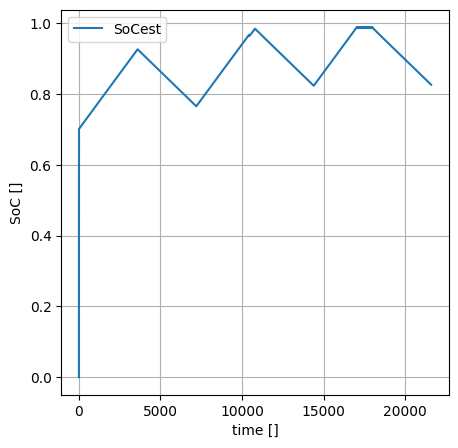

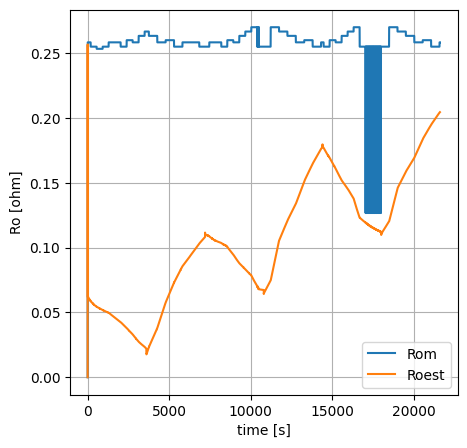

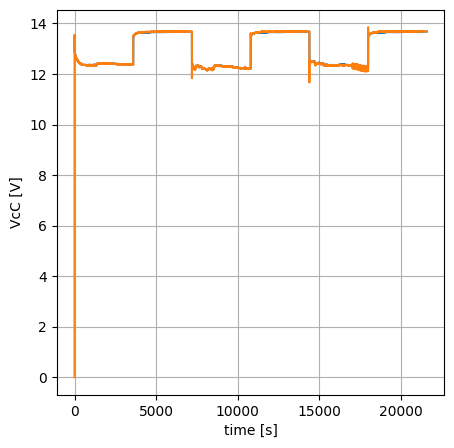

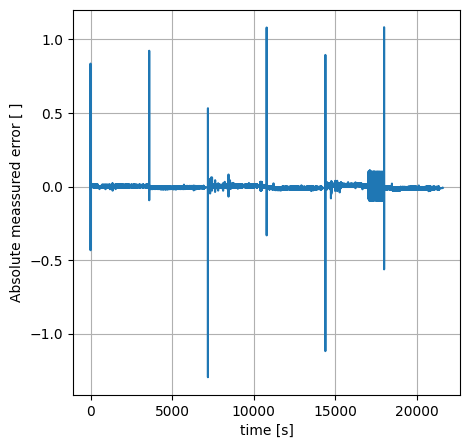

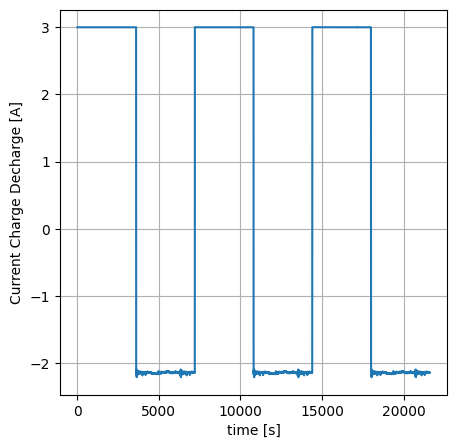

In [ ]:
figure = plt.figure(figsize= (5,5))
plt.plot(SoC_est)
plt.xlabel("time []")
plt.ylabel("SoC []")
plt.grid()
plt.legend(['SoCest'])
plt.show()

figure = plt.figure(figsize= (5,5))
plt.plot(Ro_m)
plt.plot(Ro_est)
plt.xlabel("time [s]")
plt.ylabel("Ro [ohm]")
plt.grid()
plt.legend(['Rom','Roest'])
plt.show()

figure = plt.figure(figsize= (5,5))
plt.plot(VcCtest)
plt.plot(VcC_est)
plt.xlabel("time [s]")
plt.ylabel("VcC [V]")
plt.grid()
plt.show()

figure = plt.figure(figsize= (5,5))
plt.plot(E_m)
plt.xlabel("time [s]")
plt.ylabel("Absolute meassured error [ ]")
plt.grid()
plt.show()

figure = plt.figure(figsize= (5,5))
plt.plot(Curtest)
plt.xlabel("time [s]")
plt.ylabel("Current Charge Decharge [A]")
plt.grid()
plt.show()